<a href="https://colab.research.google.com/github/ascarola17/AIEdge-ASL-Project/blob/main/ASL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Restart Runtime
Quick way to restart the runtime

In [ ]:
import os
os._exit(00)



#Install dependencies
Install dependices and necessary libaries

In [ ]:
# Install essential libraries
!pip install torch==2.3.0 torchvision==0.18.1
!pip install diffusers transformers datasets accelerate
#!pip install mediapipe opencv-python
#!pip install diffusers datasets transformers accelerate

# Download the Mediapipe hand landmarker model
#!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task


INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==2.3.0 and torchvision==0.18.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==2.3.0
    torchvision 0.18.1 depends on torch==2.3.1

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s 

#Load Specific pre-trained diffusion model
From hugging Face Model Hub , this provides an easy way to load and interact with pre-trained diffusion models.

In [ ]:
import torch
from torch import nn
from diffusers import UNet2DModel

class ClassConditionedUnet(nn.Module):
    def __init__(self, model_name, num_classes=26, class_emb_size=4):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_size)
        self.model = UNet2DModel.from_pretrained(model_name, low_cpu_mem_usage=False, ignore_mismatched_sizes=True)
        self.model.config.in_channels = 7 + class_emb_size

        old_conv = self.model.conv_in
        self.model.conv_in = nn.Conv2d(
            3 + class_emb_size,
            old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding
        )

        with torch.no_grad():
            self.model.conv_in.weight[:, :old_conv.in_channels, :, :] = old_conv.weight
            if self.model.conv_in.weight.size(1) > old_conv.in_channels:
                nn.init.normal_(self.model.conv_in.weight[:, old_conv.in_channels:, :, :], 0, 0.02)
            if self.model.conv_in.bias is not None:
                self.model.conv_in.bias = old_conv.bias
    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        class_cond = self.class_emb(class_labels).view(bs, -1, 1, 1).expand(bs, -1, w, h)
        net_input = torch.cat((x, class_cond), 1)
        return self.model(net_input, t)

    def save_pretrained(self, save_directory):
        self.model.save_pretrained(save_directory, low_cpu_mem_usage=False, ignore_mismatched_sizes=True)
        torch.save(self.class_emb.state_dict(), f"{save_directory}/class_emb.pth")

    @classmethod
    def from_pretrained(cls, model_name, save_directory, num_classes=26, class_emb_size=4):
        model = cls(model_name, num_classes, class_emb_size)
        model.model = UNet2DModel.from_pretrained(save_directory, low_cpu_mem_usage=False, ignore_mismatched_sizes=True)
        old_conv = model.model.conv_in
        model.model.conv_in = nn.Conv2d(
            7 + class_emb_size,
            old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding )

        with torch.no_grad():
            # Copy all 7 channels from the old weights
            model.model.conv_in.weight[:, :7, :, :] = old_conv.weight
            # If there are any additional channels (which there shouldn't be in this case),
            # initialize them randomly
            if model.model.conv_in.weight.size(1) > 7:
                nn.init.normal_(model.model.conv_in.weight[:, 7:, :, :], 0, 0.02)
            if model.model.conv_in.bias is not None:
                model.model.conv_in.bias = old_conv.bias
                model.class_emb.load_state_dict(torch.load(f"{save_directory}/class_emb.pth"))
                return model


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
model_name = "dyllanesl/ASL_Diffusion_Model"  # Example smaller model
#model_name = "google/ddpm-cifar10-32"

# Instantiate the custom class with the pre-trained model configuration
custom_model = ClassConditionedUnet(model_name)

# Move the model to GPU if available
custom_model.to("cuda")
#custom_model = custom_model.to("cpu")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_2.weight', 'class_embedding.linear_1.weight', 'class_embedding.linear_1.bias', 'class_embedding.linear_2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ClassConditionedUnet(
  (class_emb): Embedding(26, 4)
  (model): UNet2DModel(
    (conv_in): Conv2d(7, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=128, out_features=512, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=512, out_features=512, bias=True)
    )
    (class_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=128, out_features=512, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 1

In [ ]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("dyllanesl/ASL_Diffusion_Model")

model_index.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/143M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: Cannot load <class 'diffusers.models.unets.unet_2d.UNet2DModel'> from /root/.cache/huggingface/hub/models--dyllanesl--ASL_Diffusion_Model/snapshots/465078be9ee851cdf8f4c1e7ad1a7a7635da379a because the following keys are missing: 
 class_embedding.linear_2.weight, class_embedding.linear_1.weight, class_embedding.linear_1.bias, class_embedding.linear_2.bias. 
 Please make sure to pass `low_cpu_mem_usage=False` and `device_map=None` if you want to randomly initialize those weights or else make sure your checkpoint file is correct.

In [ ]:
def check_model(model, num_classes=26, class_emb_size=4):
    print("1. Model Structure Check:")
    print(model)
    print("\n2. Conv_in Layer Check:")
    print(f"Conv_in input channels: {model.model.conv_in.in_channels}")
    print(f"Conv_in weight shape: {model.model.conv_in.weight.shape}")

    print("\n3. Forward Pass Check:")
    # Create dummy inputs
    batch_size = 2
    channels = 3
    height = 64
    width = 64
    x = torch.randn(batch_size, channels, height, width)
    t = torch.randint(0, 1000, (batch_size,))

    # Generate dummy class labels
    class_labels = torch.randint(0, num_classes, (batch_size,))

    try:
        with torch.no_grad():
            output = model(x, t, class_labels)
        print("Forward pass successful")
        print(f"Output shape: {output.sample.shape}")
    except Exception as e:
        print(f"Forward pass failed with error: {e}")

    print("\n4. Parameter Check:")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params}")

    # Check if class embedding was added correctly
    expected_in_channels = 3 + class_emb_size
    actual_in_channels = model.model.conv_in.in_channels
    if actual_in_channels == expected_in_channels:
        print(f"Input channels correct: {actual_in_channels}")
    else:
        print(f"Input channels mismatch. Expected: {expected_in_channels}, Got: {actual_in_channels}")

# Instantiate your model
model_name = "dyllanesl/ASL_Diffusion_Model"
custom_model = ClassConditionedUnet(model_name)

# Run the checks
check_model(custom_model)

#Train Model Here
In this cell we upload the csv file to then use to combine with our images then push the final dataset combined to HuggingFace

In [ ]:
# Convert the dataset to a pandas DataFrame
# Load the CSV file with labels
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

csv_filename = list(uploaded.keys())[0]

labels_df = pd.read_csv("ASL_Sheet.csv")



#Pull images from hugging face
Here we get our images from a current dataset that only has images to prepare to combine with the labels

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("ascar17/ASLPics")

print(dataset)
print(dataset["train"][0])

Resolving data files:   0%|          | 0/78 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 78
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x300 at 0x7E933B06B490>}


#Testing
Here we see if this was done correctly by trying to display the first image to check if this was successful, while also displaying the label column to further confirm this

In [ ]:
#Import io and PIL
from io import BytesIO
from PIL import Image

#Print the first item in the dataset
image = dataset["train"][0]['image']
image

#display
labels_df['label']

0     A
1     A
2     A
3     B
4     B
     ..
73    Y
74    Y
75    Z
76    Z
77    Z
Name: label, Length: 78, dtype: object

#Push to Hugging Face
Here we upload our secret token, must use your own

In [ ]:
from google.colab import userdata
from huggingface_hub import login
login(token = userdata.get('ASL_Token'))


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#Install datasets/Combine images and labels
Here we finally combine our images and labels through a dictonary

In [ ]:
!pip install datasets

In [ ]:
print(Dataset.from_dict({'image': dataset["train"]['image'], 'label': labels_df['label']})
)

Dataset({
    features: ['image', 'label'],
    num_rows: 78
})


In [ ]:
from datasets import Dataset
#combine the images with the labels
image_dataset = Dataset.from_dict({'image': dataset["train"]['image'], 'label': labels_df['label']})
#Display
image_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 78
})

#Final Push to huggingface
Push to hugging face new dataset to save it and have it there :)

In [ ]:
#Send it to huggingface
image_dataset.push_to_hub("ascar17/FinalDataAsl")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ascar17/FinalDataAsl/commit/1df4c317589a7c973b5822cc28400f415a30f2d8', commit_message='Upload dataset', commit_description='', oid='1df4c317589a7c973b5822cc28400f415a30f2d8', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import os
#model_name = "google/ddpm-cifar10-32"  # Example smaller model
model_name = "dyllanesl/ASL_Diffusion_Model"
# Check if a saved model exists
save_directory = "/content/fine_tuned_class_conditioned_unet"
if os.path.exists(save_directory):
    print('WE use a custom model')
    custom_model = ClassConditionedUnet.from_pretrained(model_name, save_directory)
else:
    print('WE use a default model')
    custom_model = ClassConditionedUnet(model_name)

# Move the model to GPU if available
custom_model.to("cuda")

WE use a custom model


FileNotFoundError: [Errno 2] No such file or directory: '/content/fine_tuned_class_conditioned_unet/class_conditioned_unet.pth'

In [ ]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from datasets import load_dataset

dataset = load_dataset('raulit04/ASL_Dataset1')

In [ ]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
# Define preprocessing steps
preprocess = Compose([
    Resize((128, 128)),
    ToTensor(),
    Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

def preprocess_function(example):
    try:
        image = example['image']
        image = image.convert("RGB")
        image = preprocess(image)
        label = example['label']
        label = ord(label) - ord('A')
        return {"pixel_values": image, "label": label}
    except Exception as e:
        print(f"Error processing image: {e}")
        return {"pixel_values": None, "label": None}

# Apply the preprocessing function to the dataset
processed_dataset = dataset.map(preprocess_function, remove_columns=["image"])

# Check if 'pixel_values' column exists
print(f"Processed dataset length: {len(processed_dataset['train'])}")

if len(processed_dataset['train']) > 0:
    print(processed_dataset['train'][0])

# Format the dataset for PyTorch if it contains data
if len(processed_dataset['train']) > 0:
    processed_dataset['train'].set_format(type='torch', columns=['pixel_values', 'label'])

    # Inspect the preprocessed dataset
    print(processed_dataset['train'][0])
else:
    print("Processed dataset is empty.")


Processed dataset length: 650
{'label': 0, 'pixel_values': [[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9921568632125854, 0.9843137264251709, 0.9921568632125854, 0.9921568632125854, 0.9843137264251709, 0.9137254953384399, 0.9137254953384399, 0.9058823585510254, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963, 0.8901960849761963

In [ ]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from accelerate import Accelerator
import torchvision
import os
from tqdm import tqdm

# Setup
output_dir = "/content/generated_images"
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_model.to(device)

# Initialize Accelerator
accelerator = Accelerator()

# Initialize the optimizer with a higher learning rate
optimizer = AdamW(custom_model.parameters(), lr=1e-5)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Split the dataset
train_size = int(0.8 * len(processed_dataset['train']))
val_size = len(processed_dataset['train']) - train_size
train_dataset, val_dataset = random_split(processed_dataset['train'], [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Prepare the model, optimizer, and dataloaders with Accelerator
custom_model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    custom_model, optimizer, train_dataloader, val_dataloader
)

# Training parameters
num_epochs = 20
accumulation_steps = 4
patience = 10  # for early stopping
best_val_loss = float('inf')
patience_counter = 0

def denormalize(image):
    return (image * 0.5 + 0.5).clamp(0, 1)

for epoch in range(num_epochs):
    custom_model.train()
    epoch_loss = 0

    # Training loop
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for step, batch in enumerate(progress_bar):
        with accelerator.accumulate(custom_model):
            images = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            # Generate noisy images
            noise = torch.randn_like(images).to(device)
            noisy_images = images + noise * 0.1  # Increased noise level

            # Generate timesteps tensor
            timesteps = torch.randint(0, 999, (images.shape[0],), device=device)

            # Forward pass
            outputs = custom_model(noisy_images, t=timesteps, class_labels=labels)

            # Compute loss
            mse_loss = torch.nn.functional.mse_loss(outputs.sample, images)
            brightness_loss = torch.mean(1.0 - outputs.sample)
            loss = mse_loss + 0.1 * brightness_loss
            loss = loss / accumulation_steps  # Scale loss

            # Backward pass
            accelerator.backward(loss)

            if (step + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(custom_model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss += loss.item() * accumulation_steps

            # Update progress bar
            progress_bar.set_postfix({"loss": loss.item() * accumulation_steps})

        if step % 100 == 0:
            torchvision.utils.save_image(denormalize(noisy_images), os.path.join(output_dir, f'noisy_epoch{epoch}_step{step}.png'))
            torchvision.utils.save_image(denormalize(outputs.sample), os.path.join(output_dir, f'denoised_epoch{epoch}_step{step}.png'))

    # Validation loop
    custom_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            images = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)
            noise = torch.randn_like(images).to(device)
            noisy_images = images + noise * 0.1
            timesteps = torch.randint(0, 999, (images.shape[0],), device=device)
            outputs = custom_model(noisy_images, t=timesteps, class_labels=labels)
            mse_loss = torch.nn.functional.mse_loss(outputs.sample, images)
            brightness_loss = torch.mean(1.0 - outputs.sample)
            loss = mse_loss + 0.1 * brightness_loss
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss/len(train_dataloader)}, Val Loss: {val_loss}")

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        accelerator.save(custom_model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Save the model after each epoch
    accelerator.save(custom_model.state_dict(), f"model_epoch_{epoch+1}.pth")

# Load the best model
custom_model.load_state_dict(torch.load("best_model.pth"))

# Final save of the fine-tuned model
custom_model.save_pretrained("fine_tuned_class_conditioned_unet")

Epoch 1/20: 100%|██████████| 130/130 [02:39<00:00,  1.23s/it, loss=0.265]


Epoch 1/20, Train Loss: 0.37743341131852226, Val Loss: 0.25907551113403204


Epoch 2/20: 100%|██████████| 130/130 [02:38<00:00,  1.22s/it, loss=0.124]


Epoch 2/20, Train Loss: 0.18333202090400916, Val Loss: 0.13533055850050665


Epoch 3/20: 100%|██████████| 130/130 [02:38<00:00,  1.22s/it, loss=0.114]


Epoch 3/20, Train Loss: 0.11275651896229157, Val Loss: 0.09687284797881589


Epoch 4/20: 100%|██████████| 130/130 [02:38<00:00,  1.22s/it, loss=0.114]


Epoch 4/20, Train Loss: 0.08803774932256112, Val Loss: 0.08134265289162144


Epoch 5/20: 100%|██████████| 130/130 [02:38<00:00,  1.22s/it, loss=0.063]


Epoch 5/20, Train Loss: 0.07614894477793803, Val Loss: 0.07148425077850168


Epoch 6/20: 100%|██████████| 130/130 [02:38<00:00,  1.22s/it, loss=0.0663]


Epoch 6/20, Train Loss: 0.0677591106066337, Val Loss: 0.06616872560345766


Epoch 7/20: 100%|██████████| 130/130 [02:39<00:00,  1.22s/it, loss=0.0474]


Epoch 7/20, Train Loss: 0.06126505729670708, Val Loss: 0.057937878438017586


Epoch 8/20: 100%|██████████| 130/130 [02:39<00:00,  1.22s/it, loss=0.039]


Epoch 8/20, Train Loss: 0.05588921967607278, Val Loss: 0.052763366225090896


Epoch 9/20: 100%|██████████| 130/130 [02:39<00:00,  1.23s/it, loss=0.0475]


Epoch 9/20, Train Loss: 0.05107556100075061, Val Loss: 0.04945690568649408


Epoch 10/20: 100%|██████████| 130/130 [02:39<00:00,  1.22s/it, loss=0.0374]


Epoch 10/20, Train Loss: 0.04695541523396969, Val Loss: 0.04619037343019789


Epoch 11/20: 100%|██████████| 130/130 [02:39<00:00,  1.22s/it, loss=0.0466]


Epoch 11/20, Train Loss: 0.04418282087605733, Val Loss: 0.04386502097953449


Epoch 12/20: 100%|██████████| 130/130 [02:39<00:00,  1.22s/it, loss=0.0509]


Epoch 12/20, Train Loss: 0.04201764144863074, Val Loss: 0.04087301908117352


Epoch 13/20: 100%|██████████| 130/130 [02:39<00:00,  1.22s/it, loss=0.0401]


Epoch 13/20, Train Loss: 0.03999371908318538, Val Loss: 0.039512022200858955


Epoch 14/20: 100%|██████████| 130/130 [02:39<00:00,  1.23s/it, loss=0.04]


Epoch 14/20, Train Loss: 0.03827690348888819, Val Loss: 0.03827331898113092


Epoch 15/20: 100%|██████████| 130/130 [02:39<00:00,  1.22s/it, loss=0.0388]


Epoch 15/20, Train Loss: 0.036942034315031305, Val Loss: 0.036807220090519295


Epoch 16/20: 100%|██████████| 130/130 [02:39<00:00,  1.22s/it, loss=0.0385]


Epoch 16/20, Train Loss: 0.035291244060947344, Val Loss: 0.03552890698792356


Epoch 17/20: 100%|██████████| 130/130 [02:39<00:00,  1.23s/it, loss=0.0319]


Epoch 17/20, Train Loss: 0.03501398212348039, Val Loss: 0.03425983294393077


Epoch 18/20: 100%|██████████| 130/130 [02:39<00:00,  1.22s/it, loss=0.037]


Epoch 18/20, Train Loss: 0.03344438813913327, Val Loss: 0.03357596763155677


Epoch 19/20: 100%|██████████| 130/130 [02:39<00:00,  1.22s/it, loss=0.0331]


Epoch 19/20, Train Loss: 0.03295657425545729, Val Loss: 0.03291069733148271


Epoch 20/20: 100%|██████████| 130/130 [02:39<00:00,  1.23s/it, loss=0.0308]


Epoch 20/20, Train Loss: 0.03216133387042926, Val Loss: 0.03221295096657493


In [ ]:
torch.save(custom_model.class_emb.state_dict(), "fine_tuned_class_conditioned_unet/class_emb.pth")


#Display the noisy/denoisy data
Work on
Take into account label only is taking into account image atm

#Single Image generation
dont run untill above complete



In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing the generated images
output_dir = "/content/generated_images"

# List all files in the directory
generated_images = os.listdir(output_dir)
print("Generated Images:", generated_images)

# Function to display an image
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Display a specific generated image
image_to_display = os.path.join(output_dir, generated_images[0])  # Change index to display a different image
display_image(image_to_display)


Multiple image geneation
dont run ethier atm

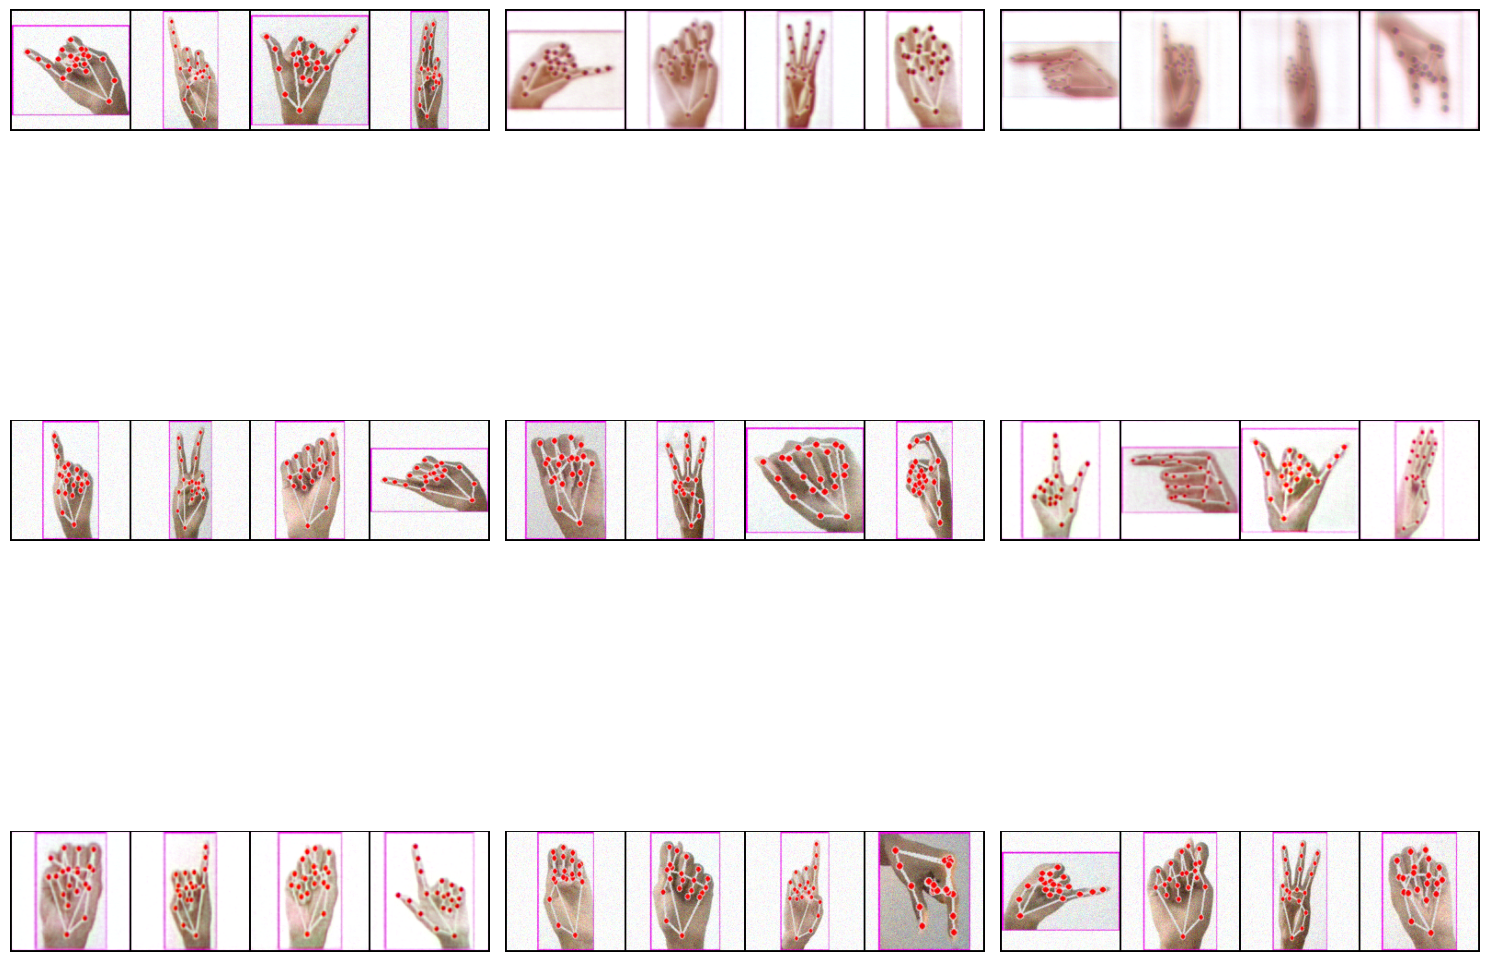

In [ ]:
import matplotlib.pyplot as plt

# Display multiple images in a grid
def display_images(image_paths, cols=3, rows=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for ax, img_path in zip(axes.flatten(), image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get paths for a few generated images
image_paths = [os.path.join(output_dir, img) for img in generated_images[:26]]  # Adjust the number of images as needed
display_images(image_paths)

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import HfApi, create_repo
import os
from google.colab import userdata


api = HfApi()
repo_id = "dyllanesl/ASL_Diffusion_Model"  # Your repository name
token = userdata.get('Save_Token')  # Your Hugging Face token

# Create the repository if it doesn't exist
try:
    temp = api.repo_info(repo_id, repo_type="model", token=token)
    print(temp)
except RepositoryNotFoundError:
    create_repo(repo_id, repo_type="model", token=token)

# Define the path to the directory and the files
directory_path = "/content/fine_tuned_class_conditioned_unet"
files = ["config.json", "class_emb.pth", "diffusion_pytorch_model.safetensors"]

# Upload each file to the repository
for file_name in files:
    file_path = os.path.join(directory_path, file_name)
    api.upload_file(
        path_or_fileobj=file_path,
        path_in_repo=file_name,
        repo_id=repo_id,
        repo_type="model",  # Change this to "dataset" if you're uploading to a dataset repository
        token=token,
        commit_message=f"Upload {file_name}"
    )

print("Files uploaded successfully.")

ModelInfo(id='dyllanesl/ASL_Diffusion_Model', author='dyllanesl', sha='3460635c99e6139f36da40044987bee7a89672ca', created_at=datetime.datetime(2024, 7, 12, 18, 54, 21, tzinfo=datetime.timezone.utc), last_modified=datetime.datetime(2024, 7, 16, 19, 18, 25, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=250, likes=0, library_name='diffusers', tags=['diffusers', 'safetensors', 'diffusers:DDPMPipeline', 'region:us'], pipeline_tag=None, mask_token=None, card_data=None, widget_data=None, model_index=None, config={'diffusers': {'_class_name': 'DDPMPipeline'}}, transformers_info=None, siblings=[RepoSibling(rfilename='.gitattributes', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='class_emb.pth', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='config.json', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='diffusion_pytorch_model.bin', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='diffusion_pytorch_model.safetens

In [ ]:
from diffusers import UNet2DModel
# Define the model path
model_path = "dyllanesl/ASL_Diffusion_Model"

# Initialize and load the custom model
custom_model = ClassConditionedUnet(model_path)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_model.to("cpu")



Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized because the shapes did not match:
- conv_out.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([7]) in the model instantiated
- conv_out.weight: found shape torch.Size([3, 128, 3, 3]) in the checkpoint and torch.Size([7, 128, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ClassConditionedUnet(
  (class_emb): Embedding(26, 4)
  (model): UNet2DModel(
    (conv_in): Conv2d(7, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=128, out_features=512, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
     

In [ ]:
import torch
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="linear")

In [ ]:
def generate_image(label, num_inference_steps=50, guidance_scale=7.5):
    # Start from random noise
    image = torch.randn((1, 3, 128, 128)).to(device)

    # Convert label to tensor
    label_tensor = torch.tensor([label]).to(device)

    # Denoise the image
    for t in scheduler.timesteps[:num_inference_steps]:
        with torch.no_grad():
            noise_pred = custom_model(image, t.unsqueeze(0).to(device), class_labels=label_tensor)

        # Guidance
        noise_pred_uncond = custom_model(image, t.unsqueeze(0).to(device), class_labels=torch.tensor([-1]).to(device))
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred - noise_pred_uncond)

        # Scheduler step
        image = scheduler.step(noise_pred, t, image).prev_sample

    # Denormalize the image
    image = (image / 2 + 0.5).clamp(0, 1)
    return image

In [ ]:
import torch
import matplotlib.pyplot as plt
import os

def show_image(image_tensor):
    plt.figure(figsize=(10, 10))
    plt.imshow(image_tensor.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

# Function to generate images from labels using the saved model
def generate_image_from_saved_model(label, model_path, device, img_size=256):
    # Load the saved model
    model = ClassConditionedUnet.from_pretrained(model_path,save_directory)
    model.to(device)
    model.eval()

    # Create a random noise tensor
    noise = torch.randn(1, 3, img_size, img_size).to(device)

    # Create a tensor for the label
    labels = torch.tensor([label], dtype=torch.long).to(device)

    with torch.no_grad():
        # Generate a time step tensor
        timesteps = torch.tensor([999], dtype=torch.long).to(device)  # assuming 999 is the max timestep

        # Generate an image from the noise and label
        generated_image = model(noise, t=timesteps, class_labels=labels).sample

    return generated_image

# Define your model loading code
save_directory = "/content/fine_tuned_class_conditioned_unet"
model_path = 'dyllanesl/ASL_Diffusion_Model'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate and display images for each label
for label in range(26):  # Assuming 26 labels for ASL alphabet
    try:
        print(f"Generating image for label {chr(65 + label)}")  # Debug print statement
        generated_image = generate_image_from_saved_model(label, model_path, device)
        show_image(generated_image[0])
        print(f"Generated image for label {chr(65 + label)}")  # Convert label to corresponding ASCII letter
    except Exception as e:
        print(f"Error generating image for label {chr(65 + label)}: {e}")


Generating image for label A


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label A: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label B


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label B: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label C


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label C: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label D


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label D: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label E


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label E: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label F


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label F: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label G


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label G: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label H


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label H: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label I


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label I: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label J


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label J: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label K


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label K: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label L


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label L: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label M


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label M: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label N


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label N: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label O


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label O: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label P


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label P: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label Q


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label Q: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label R


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label R: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label S


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label S: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label T


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label T: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label U


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label U: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label V


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label V: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label W


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label W: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label X


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label X: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label Y


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label Y: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]
Generating image for label Z


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized: ['class_embedding.linear_1.weight', 'class_embedding.linear_2.weight', 'class_embedding.linear_2.bias', 'class_embedding.linear_1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error generating image for label Z: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [128, 7, 3, 3].  Tensor sizes: [128, 3, 3, 3]


In [ ]:
import torch
from torch import nn
from diffusers import DDPMScheduler
from PIL import Image
import numpy as np

# Instantiate the custom model
model_name = "dyllanesl/ASL_Diffusion_Model"
num_classes = 26
class_emb_size = 4
model = ClassConditionedUnet(model_name, num_classes, class_emb_size)

# Load the state dict if necessary
save_directory = "path_to_your_model_directory"
model.load_state_dict(torch.load(f"{save_directory}/class_conditioned_unet.pth"))

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


NameError: name 'ClassConditionedUnet' is not defined